In [1]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
import pandas as pd
import numpy as np
import importlib
from tqdm import tqdm
from datetime import datetime
from bs4 import BeautifulSoup 
from osgeo import gdal, osr
import copy
import re
from functools import reduce

import helper_functions.plot_utils
import helper_functions.routing.floodedRouting
import helper_functions.raster_utils
import LTA_API_key
import helper_functions.routing.dryRouting

importlib.reload(helper_functions.routing.floodedRouting)
importlib.reload(helper_functions.raster_utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(LTA_API_key)
importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.routing.dryRouting)

import helper_functions.routing.floodedRouting as floodedRouting
import helper_functions.raster_utils as raster_utils
import helper_functions.utils as utils
import helper_functions.plot_utils as plot_utils
import LTA_API_key as apiKeys
import helper_functions.utils as utils
import helper_functions.routing.dryRouting as dryRouting

# How will flood affect emergency medical service (EMS)?

### Get hospitals with emergency department

In [19]:
hospitals_EMS = ["Changi General Hospital",
                 "KK Women's and Children's Hospital",
                 "Sengkang General Hospital",
                 "Singapore General Hospital",
                 "Khoo Teck Puat Hospital",
                 "TTSH",
                 "Woodlands Health Campus",
                 "Alexandra Hospital",
                 "NUH",
                 "Ng Teng Fong General Hospital",
                 "Farrer Park Hospital",
                 "Mount Elizabeth Hospital",
                 "Mount Elizabeth Novena Hospital",
                 "Parkway East Hospital",
                 "Raffles Hospital"]

In [ ]:
# hospital_locations = []
# headers = apiKeys.generate_OneMap_headers()
# for hospital in hospitals_EMS:
#     response = apiKeys.get_coordinates_from_location(hospital,headers)
#     hospital_locations.append(response)

# hospital_df = pd.DataFrame(hospital_locations)
# hospital_df['Hospital'] = hospitals_EMS
# hospital_df.to_csv("Exported_Data/hospitals_EMS.csv",index=False)

In [2]:
hospital_df = pd.read_csv("Exported_Data/hospitals_EMS.csv")
hospital_df.head()

,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,Hospital
0,CGH BUILDING,131,KILLINEY ROAD,CGH BUILDING,131 KILLINEY ROAD CGH BUILDING SINGAPORE 239571,239571,28581.237670,31076.149718,1.297316,103.838541,Changi General Hospital
1,KK WOMEN'S AND CHILDREN'S HOSPITAL,100,BUKIT TIMAH ROAD,KK WOMEN'S AND CHILDREN'S HOSPITAL,100 BUKIT TIMAH ROAD KK WOMEN'S AND CHILDREN'S...,229899,29501.837577,32532.855972,1.310490,103.846813,KK Women's and Children's Hospital
2,SENGKANG GENERAL HOSPITAL,1,ANCHORVALE STREET,SENGKANG GENERAL HOSPITAL,1 ANCHORVALE STREET SENGKANG GENERAL HOSPITAL ...,544835,34601.703260,41957.730616,1.395725,103.892640,Sengkang General Hospital
3,SGH BLK 4 (TAXI STAND),NaN,NIL,SGH BLK 4 (TAXI STAND),SGH BLK 4 (TAXI STAND),NIL,28214.878687,29087.837363,1.279335,103.835249,Singapore General Hospital
4,KHOO TECK PUAT HOSPITAL,90,YISHUN CENTRAL,KHOO TECK PUAT HOSPITAL,90 YISHUN CENTRAL KHOO TECK PUAT HOSPITAL SING...,768828,28585.395401,45093.160872,1.424081,103.838579,Khoo Teck Puat Hospital


# Import car network

In [3]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_car_network.graphml"
G_car = ox.load_graphml(os.path.join(save_dir,filename))

In [4]:
hospital_df["nodeID"] = hospital_df.apply(lambda row: ox.nearest_nodes(G_car,row["LONGITUDE"],row["LATITUDE"]),axis=1)
hospital_df.head()

,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,Hospital,nodeID
0,CGH BUILDING,131,KILLINEY ROAD,CGH BUILDING,131 KILLINEY ROAD CGH BUILDING SINGAPORE 239571,239571,28581.237670,31076.149718,1.297316,103.838541,Changi General Hospital,6344315909
1,KK WOMEN'S AND CHILDREN'S HOSPITAL,100,BUKIT TIMAH ROAD,KK WOMEN'S AND CHILDREN'S HOSPITAL,100 BUKIT TIMAH ROAD KK WOMEN'S AND CHILDREN'S...,229899,29501.837577,32532.855972,1.310490,103.846813,KK Women's and Children's Hospital,74353691
2,SENGKANG GENERAL HOSPITAL,1,ANCHORVALE STREET,SENGKANG GENERAL HOSPITAL,1 ANCHORVALE STREET SENGKANG GENERAL HOSPITAL ...,544835,34601.703260,41957.730616,1.395725,103.892640,Sengkang General Hospital,369939966
3,SGH BLK 4 (TAXI STAND),NaN,NIL,SGH BLK 4 (TAXI STAND),SGH BLK 4 (TAXI STAND),NIL,28214.878687,29087.837363,1.279335,103.835249,Singapore General Hospital,6703954146
4,KHOO TECK PUAT HOSPITAL,90,YISHUN CENTRAL,KHOO TECK PUAT HOSPITAL,90 YISHUN CENTRAL KHOO TECK PUAT HOSPITAL SING...,768828,28585.395401,45093.160872,1.424081,103.838579,Khoo Teck Puat Hospital,244908016


Visualise locations of hospitals

<class 'geopandas.geodataframe.GeoDataFrame'>


,Name,Description,geometry,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...",BEDOK,BD,N,EAST REGION,ER,5F00E6FF084F3364,20191223152014
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...",BOON LAY,BL,N,WEST REGION,WR,C96AED188C00B2FC,20191223152014
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...",BUKIT BATOK,BK,N,WEST REGION,WR,3BEC4C829160F28A,20191223152014
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...",BUKIT MERAH,BM,N,CENTRAL REGION,CR,4850795BB0B6A4F7,20191223152014
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...",BUKIT PANJANG,BP,N,WEST REGION,WR,656F87D23D6DAB02,20191223152014


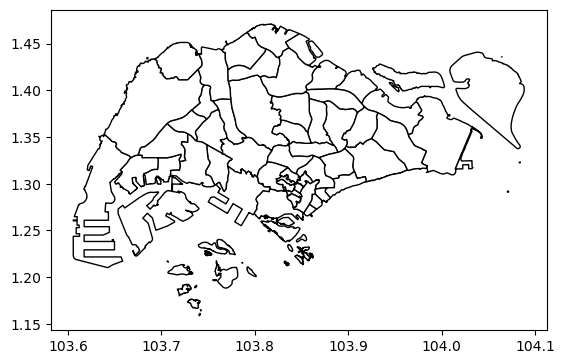

In [5]:
planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

(np.float64(1.2358857399999998), np.float64(1.47443886))


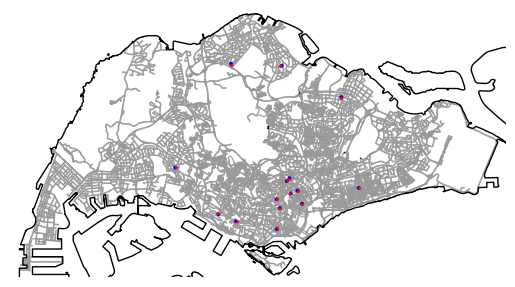

In [ ]:
hospital_nodes = hospital_df["nodeID"].to_list()
nc = ["blue" if e in hospital_nodes else "none" for e in G_car.nodes() ]
fig, ax = plt.subplots(1,1)
ox.plot_graph(G_car, node_color=nc,ax=ax,edge_alpha=0.8,node_size=8,
              show=False,close=False)
ax.scatter(hospital_df["LONGITUDE"],hospital_df["LATITUDE"],marker="P",c="red",s=2)
gpd.GeoDataFrame(geometry=[planningArea_shp.union_all()]).plot(fc="None",ec="k",ax=ax)
print(ax.get_ylim())
plt.show()

### Travel time during normal conditions

In [6]:
def get_travelTimesHospital(G, hospitals):
    """  
    Args:
        G (networkx graph): the networkx graph of the area
        hospitals (pandas dataframe): dataframe containing hospital information including node_ID and hospital coordinates
        plot (bool): whether to plot the travel times (default is True)
    """
    hospital_travel_times = [] # store list of pd.dataframes
    for i, row in hospitals.iterrows():
        center_node = row["nodeID"]
        hospital_name = row["Hospital"]
        # returns a dict keyed by target, values are shortest path length from the source to the target
        route_times = nx.shortest_path_length(G,source=center_node, target=None, weight="travel_time")
        df = pd.DataFrame.from_dict({'nodeID':list(route_times),f'{hospital_name}_travel_time':list(route_times.values())}).set_index("nodeID")
        hospital_travel_times.append(df)
    # merge all travel times into one dataframe, join by index (node_ID)
    hospital_travel_times = pd.concat(hospital_travel_times, axis=1,join='outer')
    return hospital_travel_times

travelTimesHospital = get_travelTimesHospital(G_car, hospital_df)
print("length of travel times: ", len(travelTimesHospital))
# travelTimesHospital.reset_index().to_csv(os.path.join(r"data\simulatedExtremePluvialFlood\EMS_disruption",f"normal_condition.csv"),index=False)

travelTimesHospital.head()

length of travel times:  23724


,Changi General Hospital_travel_time,KK Women's and Children's Hospital_travel_time,Sengkang General Hospital_travel_time,Singapore General Hospital_travel_time,Khoo Teck Puat Hospital_travel_time,TTSH_travel_time,Woodlands Health Campus_travel_time,Alexandra Hospital_travel_time,NUH_travel_time,Ng Teng Fong General Hospital_travel_time,Farrer Park Hospital_travel_time,Mount Elizabeth Hospital_travel_time,Mount Elizabeth Novena Hospital_travel_time,Parkway East Hospital_travel_time,Raffles Hospital_travel_time
nodeID,,,,,,,,,,,,,,,
6344315909,0.000000,199.101587,812.291199,230.438206,936.235187,300.867919,1003.963994,343.027706,460.485725,723.487011,267.483611,115.290180,255.245580,603.598682,198.625931
6344315910,1.185495,200.287082,813.476693,231.623701,937.420682,302.053414,1005.149489,344.213200,461.671220,724.672506,268.669106,116.475675,256.431074,604.784177,199.811426
4598515819,1.781701,200.883288,814.072900,229.185785,938.016888,302.649620,1005.745695,341.403584,458.861603,721.862889,269.265312,117.071881,257.027280,605.380383,200.407632
5233220877,2.878216,201.979804,815.169415,230.282300,939.113403,303.746136,1006.842210,342.500099,459.958118,722.959404,270.361827,118.168397,258.123796,606.476898,201.504147
5233220878,3.821966,202.923554,816.113165,231.226050,940.057153,304.689886,1007.785960,343.443849,460.901868,723.903155,271.305577,119.112147,259.067546,607.420648,202.447897


In [7]:
def plot_travelTimeHospital(G,travelTimesHospital,ax=None,cbar=None,
                            cmap="plasma",node_size=2,node_alpha=0.5,**kwargs):
    """   
    Args:
        G (networkx graph): the networkx graph of the area
        travelTimesHospital (pd.DataFrame): index are nodes, column is travel times in seconds
    """
    min_travel_time_dict = travelTimesHospital.min(axis=1).to_dict()
    # sort dict based on the value i.e. route times
    route_times = {k: v for k, v in sorted(min_travel_time_dict.items(), key=lambda item: item[1])}
    
    # define cbar
    vmin = min(list(min_travel_time_dict.values()))
    vmax = max(list(min_travel_time_dict.values()))
    # assign colours to travel time
    if cbar is None:
        cbar = plot_utils.get_colorbar(vmin=vmin,vmax=vmax,cmap=cmap,plot=False)
    iso_colors = [mpl.colors.rgb2hex(cbar.to_rgba(i),keep_alpha=True) for i in route_times.values()]
    # map nodes to colours
    node_colors = {node: nc_ for node, nc_ in zip(list(route_times),iso_colors)}
    nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes() ]
    ns = [node_size if node in node_colors else 0 for node in G.nodes()]
    
    fig, ax = ox.plot_graph(
            G,
            ax=ax,
            node_color=nc,
            node_size=ns,
            node_alpha=node_alpha,
            edge_linewidth=0, # If 0, then skip plotting the edges.
            show = False,
            close = False,
            **kwargs
        )
    return cbar

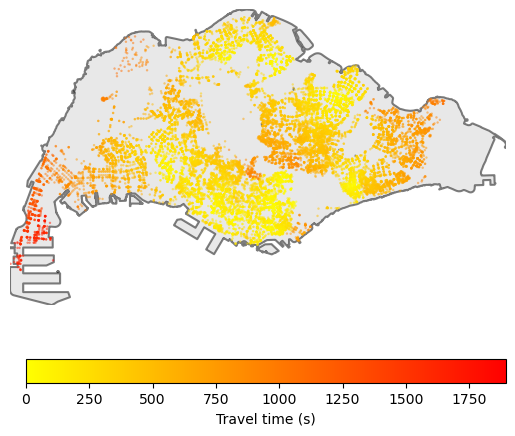

In [22]:
planningArea_shp_mainland = planningArea_shp[~planningArea_shp["PLN_AREA_N"].str.contains("ISLAND")]
minx = planningArea_shp_mainland.bounds["minx"].min()
miny = planningArea_shp_mainland.bounds["miny"].min()
maxx = planningArea_shp_mainland.bounds["maxx"].max()
maxy = planningArea_shp_mainland.bounds["maxy"].max()

bbox = (minx, miny, maxx - 4e-4*maxx, maxy)

fig, ax = plt.subplots(1,1)
gpd.GeoDataFrame(geometry=[planningArea_shp_mainland.union_all()]).plot(fc="lightgray",ec="k",ax=ax,
                                                                        alpha=0.5,lw=1.5)
cbar = plot_travelTimeHospital(G_car,travelTimesHospital,ax=ax,
                            cmap="autumn_r",node_size=3,node_alpha=0.5,bbox=bbox)
# plot colorbar
# create cax to add colorbar to the figure
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.07, 0.75, 0.05]) # left, bottom, width, height
fig.colorbar(cbar, cax=cbar_ax, orientation="horizontal", label="Travel time (s)")
plt.show()

# Import flooded edges

In [8]:
save_dir = r"data\simulatedExtremePluvialFlood"
flood_depth_fps = [os.path.join(save_dir,fp) for fp in os.listdir(save_dir) if fp.startswith("flood_depth")][:-1]
def rename_keys(k):
    name = os.path.splitext(os.path.basename(k))[0]
    return name.replace("flood_depth_","")
flood_depth = {rename_keys(fp): utils.load_pickle(fp) for fp in flood_depth_fps}
flood_depth

{'Historical_highest60mins': {(905194955,
   905194946,
   0): np.float32(0.53895694),
  (6518773358, 905193731, 0): np.float32(0.59866333),
  (6518773358, 1483360635, 0): np.float32(0.53813714),
  (244489073, 6518773357, 0): np.float32(0.57996786),
  (1483360635, 6518773357, 0): np.float32(0.50356597),
  (6518773357, 244489073, 0): np.float32(0.5320673),
  (244489161, 244489073, 0): np.float32(0.6741939),
  (244489124, 244489071, 0): np.float32(0.52124786),
  (905178500, 6164004603, 1): np.float32(0.74568516),
  (4355106387, 1483337681, 0): np.float32(0.50694275),
  (1483337681, 4355106387, 0): np.float32(0.50694275),
  (4363834597, 4355106387, 0): np.float32(0.50694275),
  (1483337681, 4355106387, 1): np.float32(0.50694275),
  (4355106387, 1483337681, 1): np.float32(0.50694275),
  (4363834590, 4355106387, 0): np.float32(0.50694275),
  (4355106387, 4363834590, 0): np.float32(0.50694275),
  (244383228, 1863993256, 0): np.float32(0.7767563),
  (1863993256, 244383228, 0): np.float32(0.75

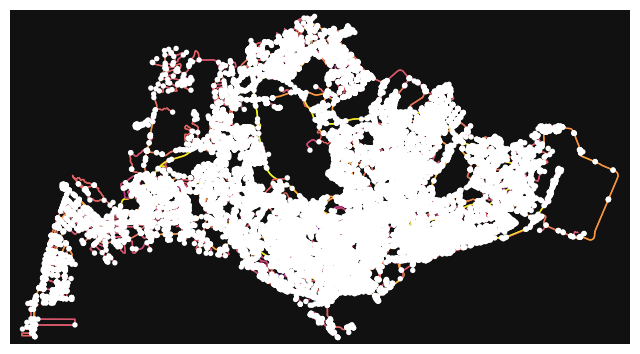

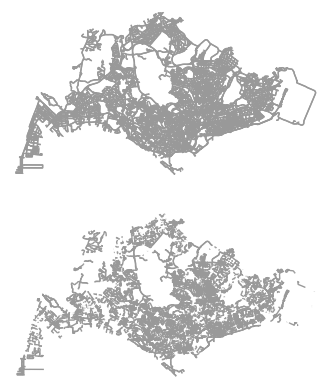

In [9]:
def drop_edges_from_G(G,flood_depth_dict,
                      flooded_maxspeed=None, percentage_reduction_maxspeed=10,
                      flood_threshold=0.7,plot=True):
    """
    Remove edges where mean flood depth is > 0.7 m
    Args:
        G (networkx graph): the networkx graph of the area
        flood_depth_dict (dict): keys are nodes, values are flood_depth in meters
        flood_threshold (float): floood depth threshold, above which, roads are assumed to impassable and edges are removed
        flooded_maxspeed (float): max speed on the road when it is flooded. Default is 20 km/h. This will override the maxspeed attribute in G.
        percentage_reduction_maxspeed (float, 0 to 100): percentage reduction from max speed allowed on roads
    Returns:
        networkx graph: graph with edges removed
    """ 
    G_copy = copy.deepcopy(G)
    
    # update flooded road network with updated flood speed
    UFN = floodedRouting.UpdateFloodNetwork(G_copy, flooded_maxspeed=flooded_maxspeed,
                                            percentage_reduction_maxspeed=percentage_reduction_maxspeed)
    G_copy = UFN.update_flooded_road_network(list(flood_depth_dict), plot=plot)
    
    # remove edges based if mean depth>flood_threshold
    remove_edges = [k for k,v in flood_depth_dict.items() if v>flood_threshold]
    for e in remove_edges:
        G_copy.remove_edge(e[0],e[1])

    if plot:
        fig, axes = plt.subplots(2,1)
        for ax, g in zip(axes.flatten(),[G,G_copy]):
            ox.plot_graph(g,
                        node_size=0,
                        ax=ax,
                        edge_linewidth=1,
                        show = False,
                        close = False
                    )
    return G_copy

drop_edges_from_G(G_car,flood_depth["V3_future_highest60mins"],flood_threshold=0.7)


# Estimate disruption to EMS under various scenarios

In [24]:
for scenario, flood_depth_dict in flood_depth.items():
    G_updated = drop_edges_from_G(G_car,flood_depth_dict,flood_threshold=0.7,
                                  flooded_maxspeed=5, percentage_reduction_maxspeed=None,
                                  plot=False)
    travelTimesHospital = get_travelTimesHospital(G_updated, hospital_df)
    travelTimesHospital.reset_index().to_csv(os.path.join(r"data\simulatedExtremePluvialFlood\EMS_disruption",f"{scenario}_1.csv"),index=False)
    

Import exported csv files on travel time

In [25]:
EMS_disruption_dir = r"data\simulatedExtremePluvialFlood\EMS_disruption"
EMS_disruption_fps = [os.path.join(EMS_disruption_dir,fp) for fp in os.listdir(EMS_disruption_dir) if bool(re.match(r"normal_condition.csv|.*_1.csv",fp))]
EMS_disruption_dfs = {os.path.splitext(os.path.basename(fp))[0]: pd.read_csv(fp).set_index("nodeID") for fp in EMS_disruption_fps}
print(list(EMS_disruption_dfs))

['Historical_highest60mins_1', 'Historical_highestDailyTotal_1', 'normal_condition', 'PUB_100RP_highest60mins_1', 'PUB_100RP_highestDailyTotal_1', 'V3_future_highest60mins_1', 'V3_future_highestDailyTotal_1']


In [26]:
scenarios = ['normal_condition','Historical_highest60mins_1','PUB_100RP_highest60mins_1','V3_future_highest60mins_1']
# minTravelTimesHospital = []
# for scenario in scenarios:
#     minTravelTimesHospital.append(EMS_disruption_dfs[scenario].min(axis=1).to_frame(name=scenario))
minTravelTimesHospital = [EMS_disruption_dfs[scenario].min(axis=1).to_frame(name=scenario).reset_index() for scenario in scenarios]
minTravelTimesHospital = reduce(lambda x, y: pd.merge(x, y, on="nodeID",how="outer"), minTravelTimesHospital)
print("length of df: ", len(minTravelTimesHospital))
len(set(minTravelTimesHospital.index.to_list()))
minTravelTimesHospital = minTravelTimesHospital.set_index("nodeID")
minTravelTimesHospital.head()

length of df:  23724


,normal_condition,Historical_highest60mins_1,PUB_100RP_highest60mins_1,V3_future_highest60mins_1
nodeID,,,,
25451915,555.416916,649.956066,555.416916,NaN
25451918,593.941429,688.480580,593.941429,NaN
25451929,333.898540,333.898540,333.898540,NaN
25455287,134.473673,134.473673,134.473673,2444.219524
25455292,271.934232,905.450848,905.450848,NaN


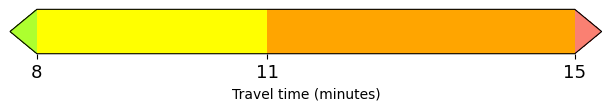

In [31]:
save_dir = r"data\simulatedExtremePluvialFlood\EMS_disruption"

def get_EMS_cbar():
    cmap = (mpl.colors.ListedColormap(['yellow', 'orange'])
        .with_extremes(under='greenyellow', over='salmon'))
    bounds = np.array([8,11,15])*60 # convert minutes to seconds
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
EMS_cbar = get_EMS_cbar()

fig, ax = plt.subplots(figsize=(6,1), layout='constrained')
clb = fig.colorbar(EMS_cbar, cax=ax, 
            orientation="horizontal", extend='both',spacing='proportional',
            label="Travel time (minutes)")
clb_labels = clb.ax.get_xticklabels()
clb_labels = [label.get_text() for label in clb_labels]
clb.ax.set_xticklabels([int(float(label)/60) for label in clb_labels], fontdict={"size":13})
save_fp = os.path.join(save_dir,f"EMS_colorbar.svg")
plt.savefig(save_fp, bbox_inches = 'tight')
plt.show()

### Plot EMS disruption

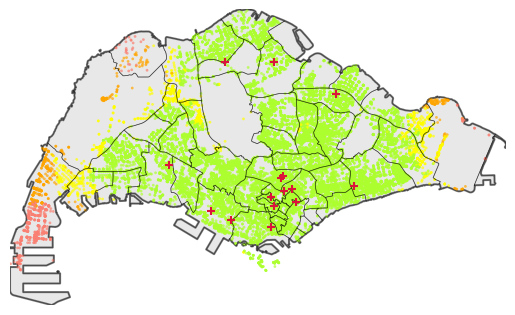

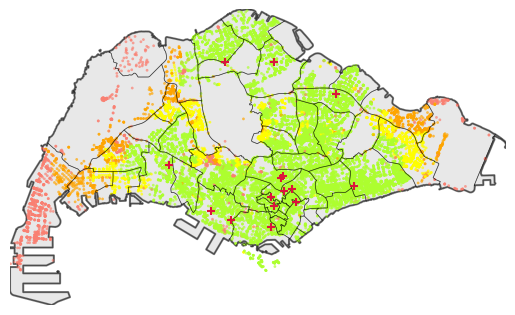

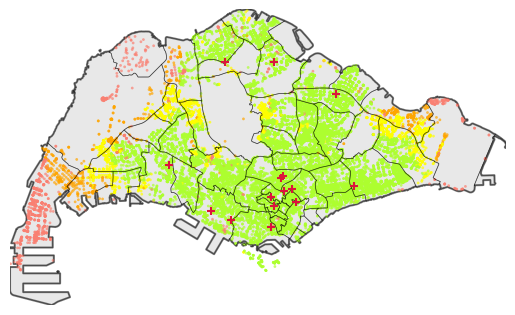

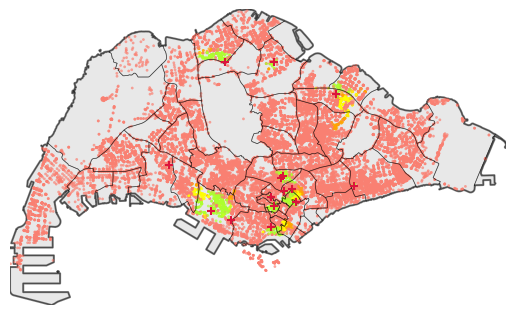

In [32]:
save_dir = r"data\simulatedExtremePluvialFlood\EMS_disruption"
for scenario in scenarios:
    fig, ax = plt.subplots(1,1)
    gpd.GeoDataFrame(geometry=[planningArea_shp_mainland.union_all()]).plot(fc="lightgray",ec="k",ax=ax,
                                                                            alpha=0.5,lw=1.5)
    # plot travel time to hospitals, if NA fill with a number greater than 15 minutes
    cbar = plot_travelTimeHospital(G_car,minTravelTimesHospital[[scenario]].fillna(20*60),ax=ax,
                                cbar=EMS_cbar,cmap="autumn_r",node_size=4,node_alpha=0.7,bbox=bbox)
    # plot planning area
    planningArea_shp_mainland.plot(fc="None",ec="k",ax=ax,alpha=0.5,lw=0.5)
    # plot hospital distribution
    ax.scatter(hospital_df["LONGITUDE"],hospital_df["LATITUDE"],marker="+",
               c="crimson",s=26,label="Hospitals with A&E")
    # plot colorbar
    # create cax to add colorbar to the figure
    # fig.subplots_adjust(bottom=0.2)
    # cbar_ax = fig.add_axes([0.15, 0.07, 0.75, 0.05]) # left, bottom, width, height
    # clb = fig.colorbar(cbar, cax=cbar_ax, 
    #             orientation="horizontal", extend='both',spacing='proportional',
    #             label="Travel time (minutes)")
    # clb_labels = clb.ax.get_xticklabels()
    # clb_labels = [label.get_text() for label in clb_labels]
    # ax.set_title(scenario)
    # clb.ax.set_xticklabels([int(float(label)/60) for label in clb_labels])
    # ax.legend(loc='lower center',bbox_to_anchor=(0.4,-0.15))
    save_fp = os.path.join(save_dir,f"EMS_{scenario}_1.png")
    plt.savefig(save_fp, bbox_inches = 'tight')
    plt.show()

### Plot effective road

- show roads with mean flood depth > 0.7 m

In [197]:
def plot_road_disruption(G,flood_depth_dict,flood_threshold=0.7,ax=None,
                    edge_color="grey",disrupted_edge_color="brickred",
                    edge_linewidth=1, disrupted_edge_linewidth=1,**kwargs):
    """
    Remove edges where mean flood depth is > 0.7 m
    Args:
        G (networkx graph): the networkx graph of the area
        flood_depth_dict (dict): keys are nodes, values are flood_depth in meters
        flood_threshold (float): floood depth threshold, above which, roads are assumed to impassable and edges are removed
    Returns:
        networkx graph: graph with edges removed
    """ 
    # edges based if mean depth>flood_threshold
    ec = []
    ew = []
    for e in G.edges(keys=True):
        try:
            if flood_depth_dict[e] >= flood_threshold:
                ec.append(disrupted_edge_color)
                ew.append(disrupted_edge_linewidth)
            else:
                ec.append(edge_color)
                ew.append(edge_linewidth)
        except:
            ec.append(edge_color)
            ew.append(edge_linewidth)

    ox.plot_graph(G,
                node_size=0,
                ax=ax,
                edge_linewidth=ew,
                edge_color=ec,
                show = False,
                close = False,
                **kwargs
            )
    return

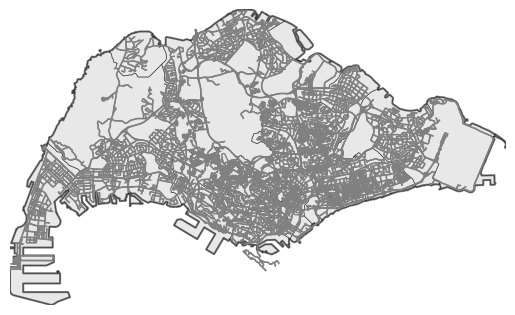

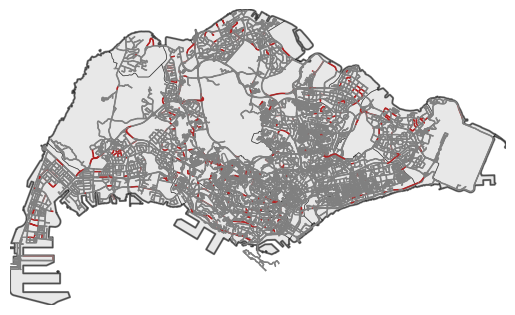

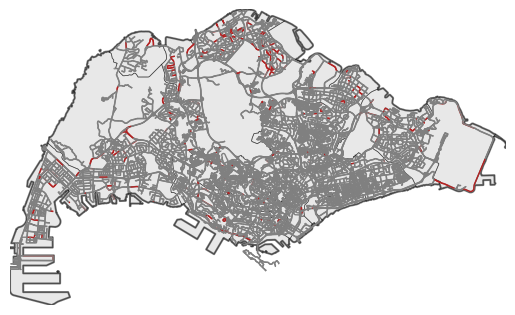

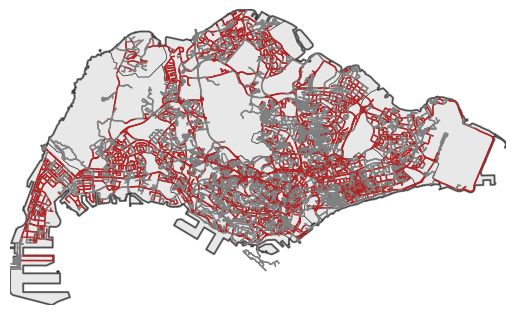

In [202]:
save_dir = r"data\simulatedExtremePluvialFlood\EMS_disruption"
edge_linewidth=1
disrupted_edge_linewidth=1
edge_color="grey"
for scenario in scenarios:    
    fig, ax = plt.subplots(1,1)
    gpd.GeoDataFrame(geometry=[planningArea_shp_mainland.union_all()]).plot(fc="lightgray",ec="k",ax=ax,
                                                                            alpha=0.5,lw=1.5)
    planningArea_shp_mainland.plot(fc="None",ec="k",ax=ax,alpha=0.5,lw=0.5)
    # ----- plot effective road network----------
    if scenario == "normal_condition":
        ox.plot_graph(G_car,
                node_size=0,
                ax=ax,
                edge_linewidth=edge_linewidth,
                edge_color=edge_color,
                show = False,
                close = False,
                bbox=bbox
            )
    else:
        plot_road_disruption(G_car,flood_depth[scenario],flood_threshold=0.7,ax=ax,
                    edge_color=edge_color,disrupted_edge_color="firebrick",
                    edge_linewidth=edge_linewidth, disrupted_edge_linewidth=disrupted_edge_linewidth,
                    bbox=bbox)
    # ax.set_title(scenario)
    save_fp = os.path.join(save_dir,f"road_disrupted_{scenario}.png")
    plt.savefig(save_fp, bbox_inches = 'tight')
    plt.show()